In [1]:
cd ../..

D:\Users\mrefoyo\Proyectos\Sub-SpaCE


In [2]:
import os
import pickle
import copy
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from sklearn import preprocessing
from tslearn.neighbors import KNeighborsTimeSeries
import tensorflow as tf
from tensorflow import keras

from experiments.experiment_utils import local_data_loader, label_encoder, nun_retrieval
from methods.outlier_calculators import AEOutlierCalculator
from experiments.evaluation.evaluation_utils import calculate_metrics

print(tf.__version__)

2.13.0


In [3]:
datasets = ['CBF', 'chinatown', 'coffee', 'gunpoint', 'ECG200']

# Load data and models.Calculate NUNs

In [4]:
data_dict = {}
models_dict = {}
outlier_calculators_dict = {}
nuns_idx_dict = {}
desired_classes_dict = {}
original_classes_dict = {}

for dataset in datasets:
    X_train, y_train, X_test, y_test = local_data_loader(str(dataset), data_path="./experiments/data")
    y_train, y_test = label_encoder(y_train, y_test)
    data_dict[dataset] = (X_train, y_train, X_test, y_test)

    # Load model
    model = keras.models.load_model(f'./experiments/models/{dataset}/{dataset}_best_model.hdf5')
    y_pred = np.argmax(model.predict(X_test), axis=1)
    original_classes_dict[dataset] = y_pred
    models_dict[dataset] = model

    # Load outlier calculator
    ae = keras.models.load_model(f'./experiments/models/{dataset}/{dataset}_ae.hdf5')
    outlier_calculator = AEOutlierCalculator(ae, X_train)
    outlier_calculators_dict[dataset] = outlier_calculator  

    # Get the NUNs
    nuns_idx = []
    desired_classes = []
    for instance_idx in range(len(X_test)):
        distances, indexes, labels = nun_retrieval(X_test[instance_idx], y_pred[instance_idx], 'euclidean', 1, X_train, y_train)
        nuns_idx.append(indexes[0])
        desired_classes.append(labels[0])
    nuns_idx_dict[dataset] = np.array(nuns_idx)
    desired_classes_dict[dataset] = np.array(desired_classes)

4/4 [==============================] - 0s 8ms/step


# Create plot

In [5]:
pd.set_option('display.max_rows', 50)
from sklearn.preprocessing import MinMaxScaler

In [6]:
dataset = "ECG200"
method = "subspace"

In [7]:
# Read fitness evolution from different methods
with open(f'./experiments/results/{dataset}/{method}.pickle', 'rb') as f:
    results = pickle.load(f)
    counterfactuals_subspace = [result['cf'] for result in results]
    fitness_evolutions_subspace = [result['fitness_evolution'] for result in results]
    cf_evolutions_subspace = [result['cf_evolution'] for result in results]

In [8]:
def create_fitnes_curve_df(fitness_evolutions, version_name):
    scaler = MinMaxScaler()
    scaled_fitness_evolutions = scaler.fit_transform(np.array(fitness_evolutions).T).T
    fitness_df = pd.DataFrame(scaled_fitness_evolutions)
    fitness_df = pd.melt(fitness_df.reset_index(), id_vars=['index'], value_vars=fitness_df.columns,
                         var_name='iteration', value_name='fitness')
    fitness_df["version"] = version_name
    return fitness_df

In [9]:
fitness_subspace_df = create_fitnes_curve_df(fitness_evolutions_subspace, "subspace")

In [10]:
complete_fitness_df = pd.concat([fitness_subspace_df])
complete_fitness_mean_df = complete_fitness_df.groupby(['iteration', 'version'])['fitness'].mean().reset_index()

<Axes: title={'center': 'Fitness evolution'}, xlabel='iteration', ylabel='fitness'>

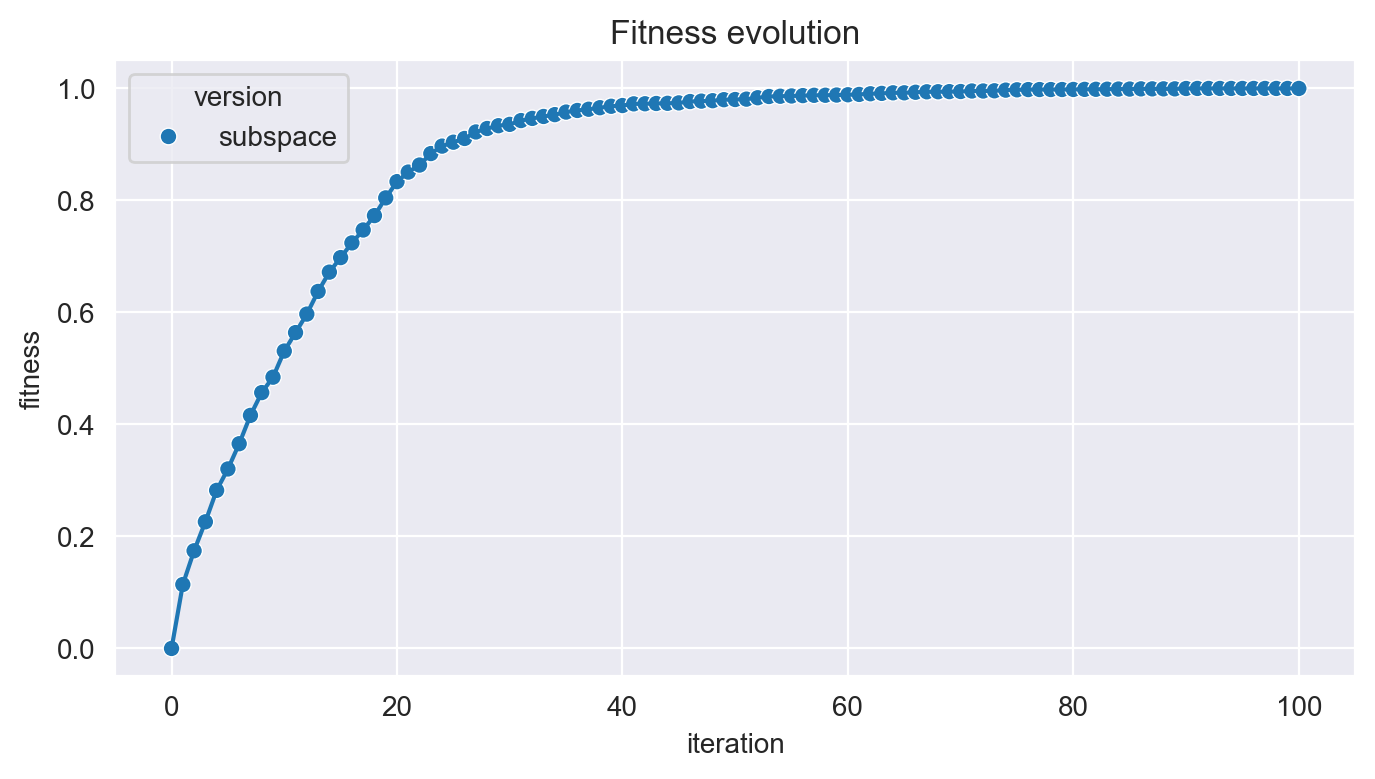

In [11]:
import seaborn as sns
plt.figure(figsize=(8, 4), dpi=200) 
sns.scatterplot(data=complete_fitness_mean_df, x="iteration", y="fitness", hue="version").set_title('Fitness evolution')
sns.lineplot(data=complete_fitness_mean_df, x="iteration", y="fitness", hue="version", legend=False)

In [66]:
def plot_single_cf(x_orig, x_cf, title='', figsize=(4, 3)):
    length = x_orig.shape[0]
    n_channels = x_orig.shape[1]
    # Get change mask 
    found_counterfactual_mask = (x_orig != x_cf.reshape(1, length, n_channels)).astype(int)
    diff_mask = np.diff(found_counterfactual_mask, prepend=0, append=0, axis=1)
    
    fig = plt.figure(figsize=figsize, dpi=300)
    grid = gridspec.GridSpec(n_channels, 1, wspace=0.2, hspace=0.2)
    sub_channel_axs = []
    for i in range(n_channels):
        ax = plt.Subplot(fig, grid[i])
        ax.plot(x_cf.reshape(1, length, n_channels)[:, :, i].flatten(), color='red')
        ax.plot(x_orig.reshape(1, length, n_channels)[:, :, i].flatten(), color="#332288")
        
        # Add fill to changes
        starts = np.clip( np.where(diff_mask[0, :, i].flatten() == 1)[0] - 1 , 0, length)
        ends = np.where(diff_mask[0, :, i].flatten() == -1)[0]
        # Iterate over the mask segments and fill them with red color
        for i in range(0, len(starts)):
            start_idx = starts[i]
            end_idx = ends[i]
            # plt.fill_between(comp_df.iloc[start_idx:end_idx].index, comp_df.min(), comp_df.max(), color='red', alpha=0.7)
            ax.axvspan(start_idx, end_idx, alpha=0.2, color='red')
            fig.add_subplot(ax)

        # Add ax to list of subplots
        sub_channel_axs.append(ax)

    # Add title and legend
    fig.suptitle(title)
    fig.legend(sub_channel_axs,     # The line objects
           labels=['x_cf', 'x_orig'],   # The labels for each line
           title="Legend Title"  # Title for the legend
           )

    return fig

In [67]:
def plot_single_fitness_function_evolution(fitness_evolution, iteration, title='', figsize=(4, 3)):
    
    fitness_aux = np.array(fitness_evolution)
    fitness_aux[iteration:] = np.nan
    iteration_list = range(len(fitness_evolution))
    
    fig = plt.figure(figsize=figsize, dpi=300)
    ax = fig.add_subplot(111)
    ax.scatter(iteration_list, fitness_aux)
    ax.plot(iteration_list, fitness_aux)
    
    fig.suptitle(title)
    ax.set_xlabel('iteration')
    ax.set_ylabel('fitness score')
    plt.tight_layout()
    
    return fig

In [58]:
instance = 13

In [56]:
X_train, y_train, X_test, y_test = data_dict[dataset]
x_orig = X_train[instance]
cf_evolutions_subspace_instance = cf_evolutions_subspace[instance]
fitness_evolution_subspace_instance = fitness_evolutions_subspace[instance]

n_iterations = len(fitness_evolution_subspace_instance)
cf_evolution_imgs = []
fitness_evolution_imgs = []
for i in range(n_iterations):
    # Get cf image
    fig = plot_single_cf(X_test[instance], cf_evolutions_subspace_instance[i], title='Counterfactual evolution')
    canvas = fig.canvas
    canvas.draw()
    image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image_flat.reshape(*reversed(canvas.get_width_height()), 3)
    plt.close()
    cf_evolution_imgs.append(image)
    
    # Get fitness evolution image
    fig = plot_single_fitness_function_evolution(fitness_evolution_subspace_instance, i, 'Fitness evolution')
    canvas = fig.canvas
    canvas.draw()
    image_flat = np.frombuffer(canvas.tostring_rgb(), dtype='uint8')
    image = image_flat.reshape(*reversed(canvas.get_width_height()), 3)
    plt.close()
    fitness_evolution_imgs.append(image)
    
# Create CF gif
cf_imgs = [Image.fromarray(img) for img in cf_evolution_imgs]
cf_imgs[0].save(f"./experiments/evaluation/gifs/{dataset}/subspace_cf_evol_i{instance}.gif", save_all=True, append_images=cf_imgs[1:], duration=100, loop=0)

# Create CF gif
fitness_imgs = [Image.fromarray(img) for img in fitness_evolution_imgs]
fitness_imgs[0].save(f"./experiments/evaluation/gifs/{dataset}/subspace_fitness_evol_i{instance}.gif", save_all=True, append_images=fitness_imgs[1:], duration=100, loop=0)

C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_17476\3929309440.py:32: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(sub_channel_axs,     # The line objects
C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_17476\3929309440.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


C:\Users\mrefoyo\AppData\Local\Temp\ipykernel_17476\1755165922.py:32: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(sub_channel_axs,     # The line objects


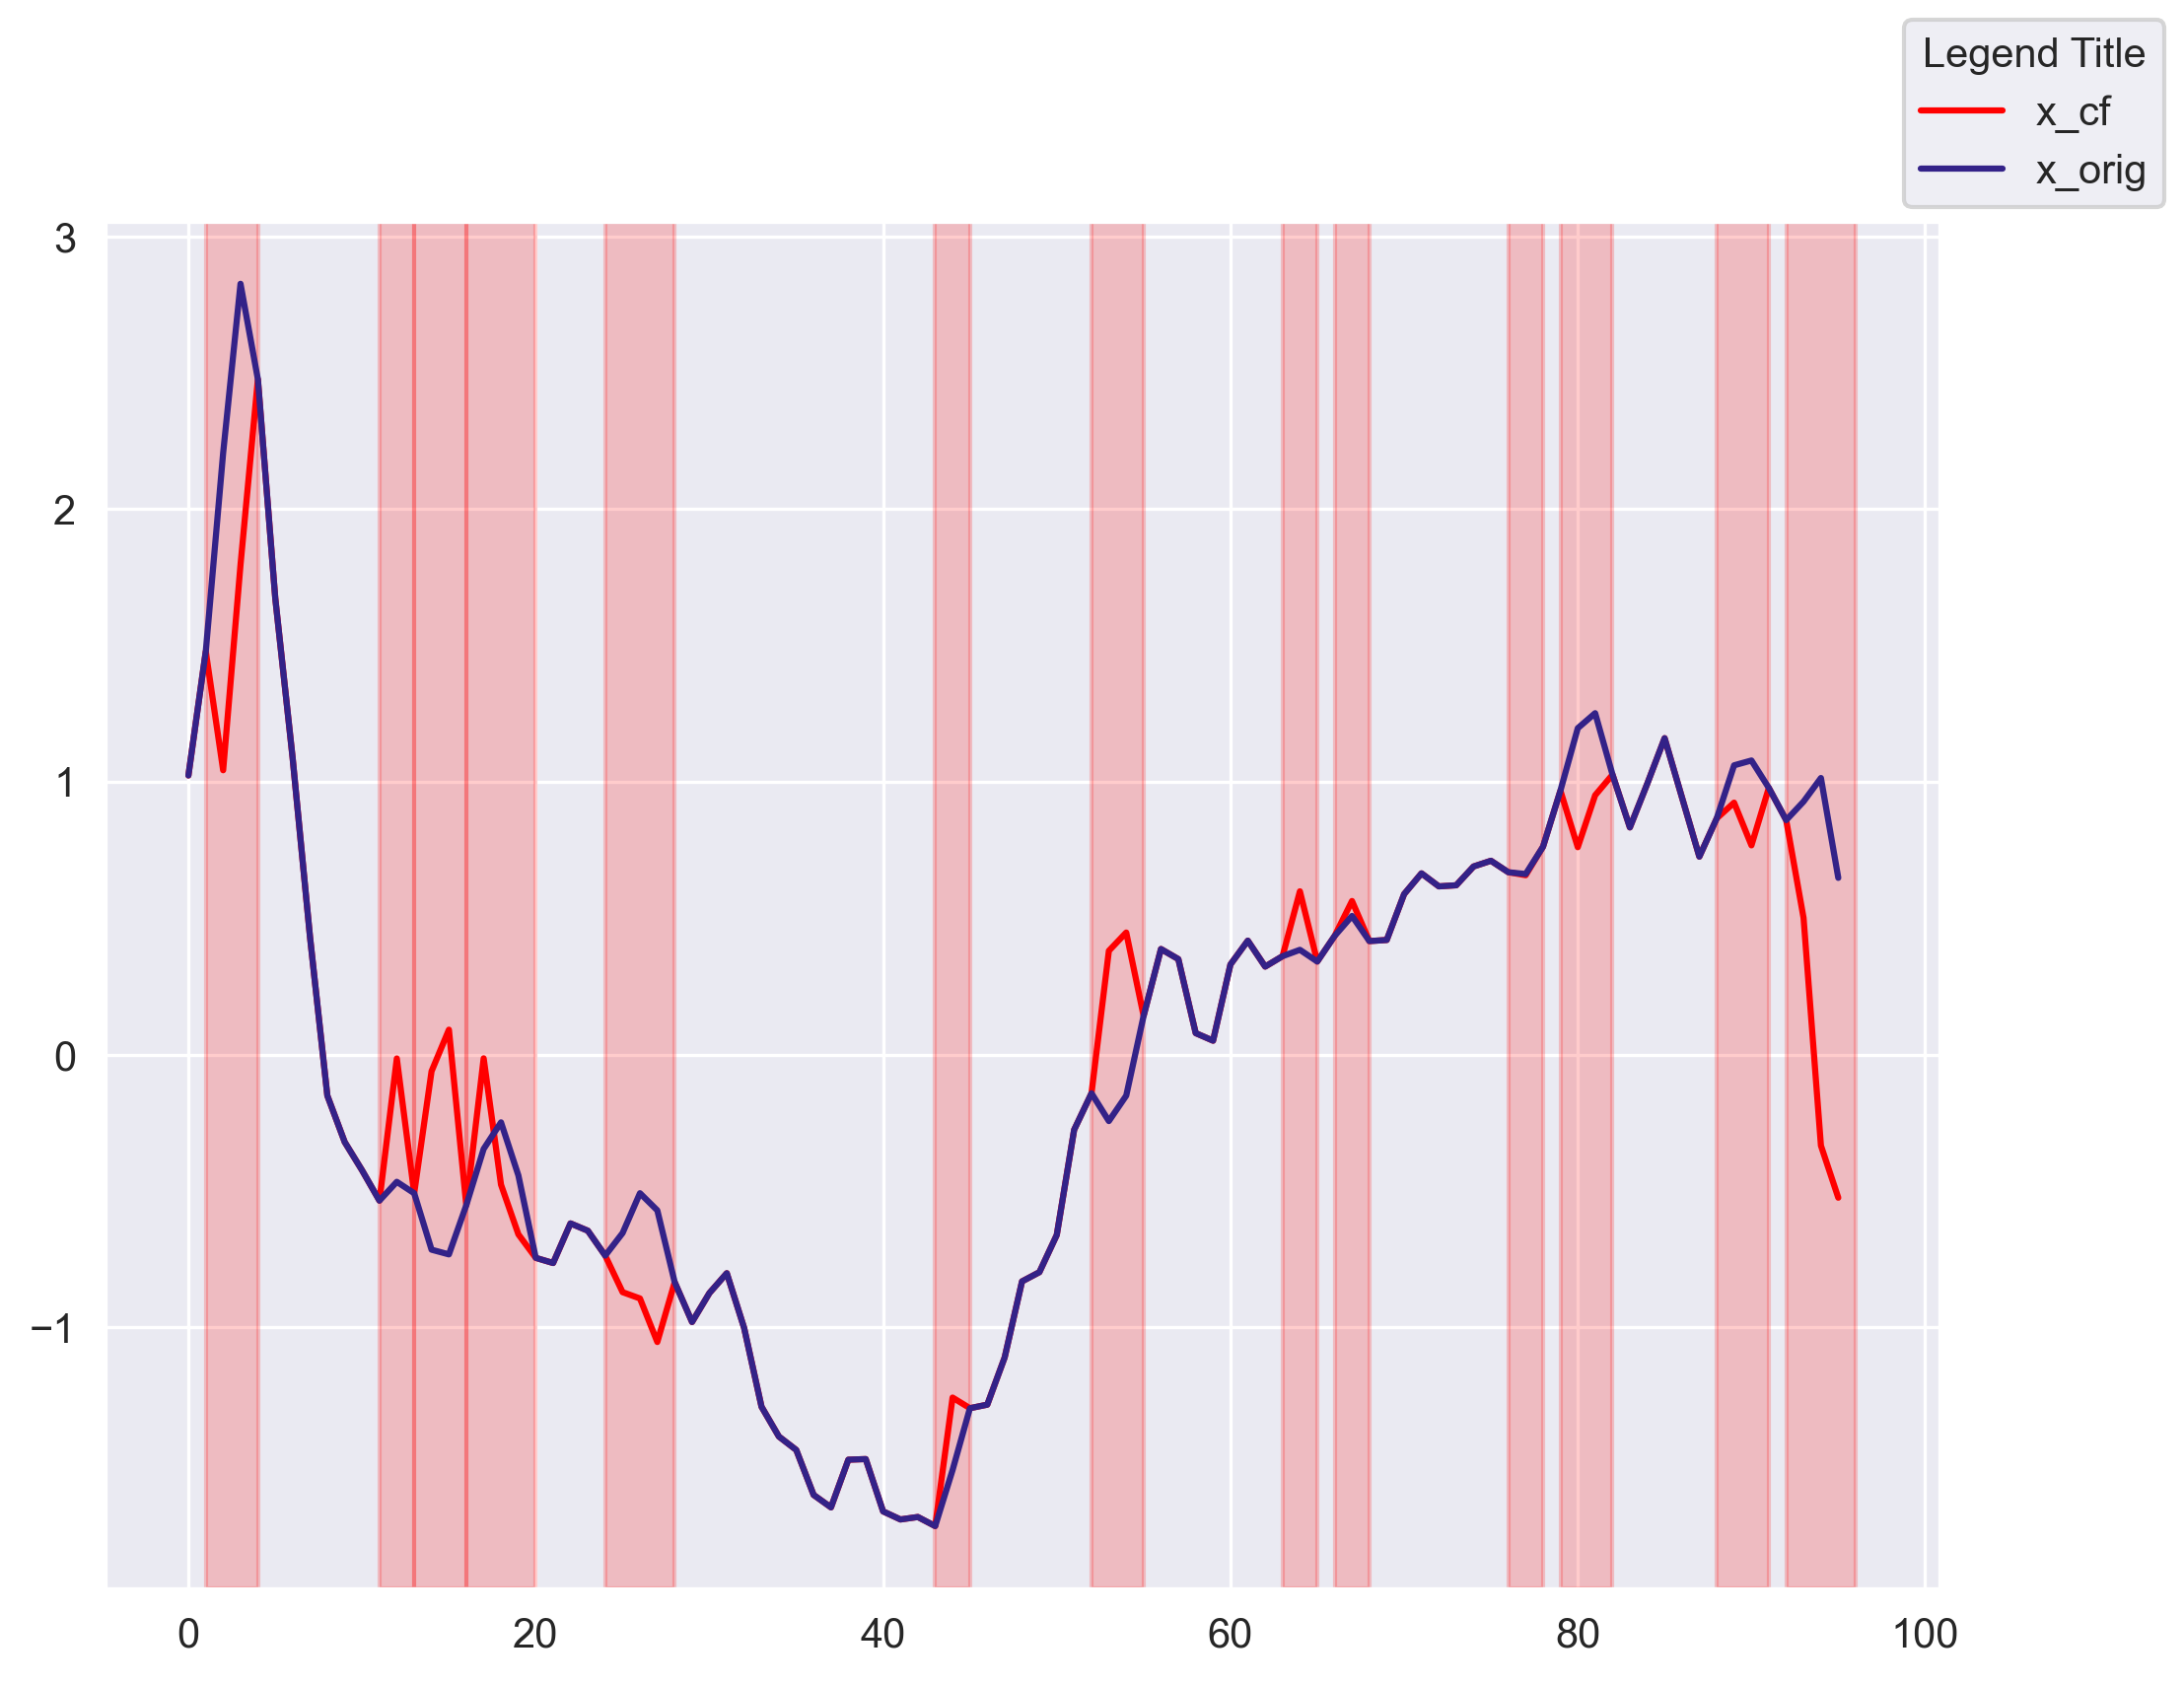

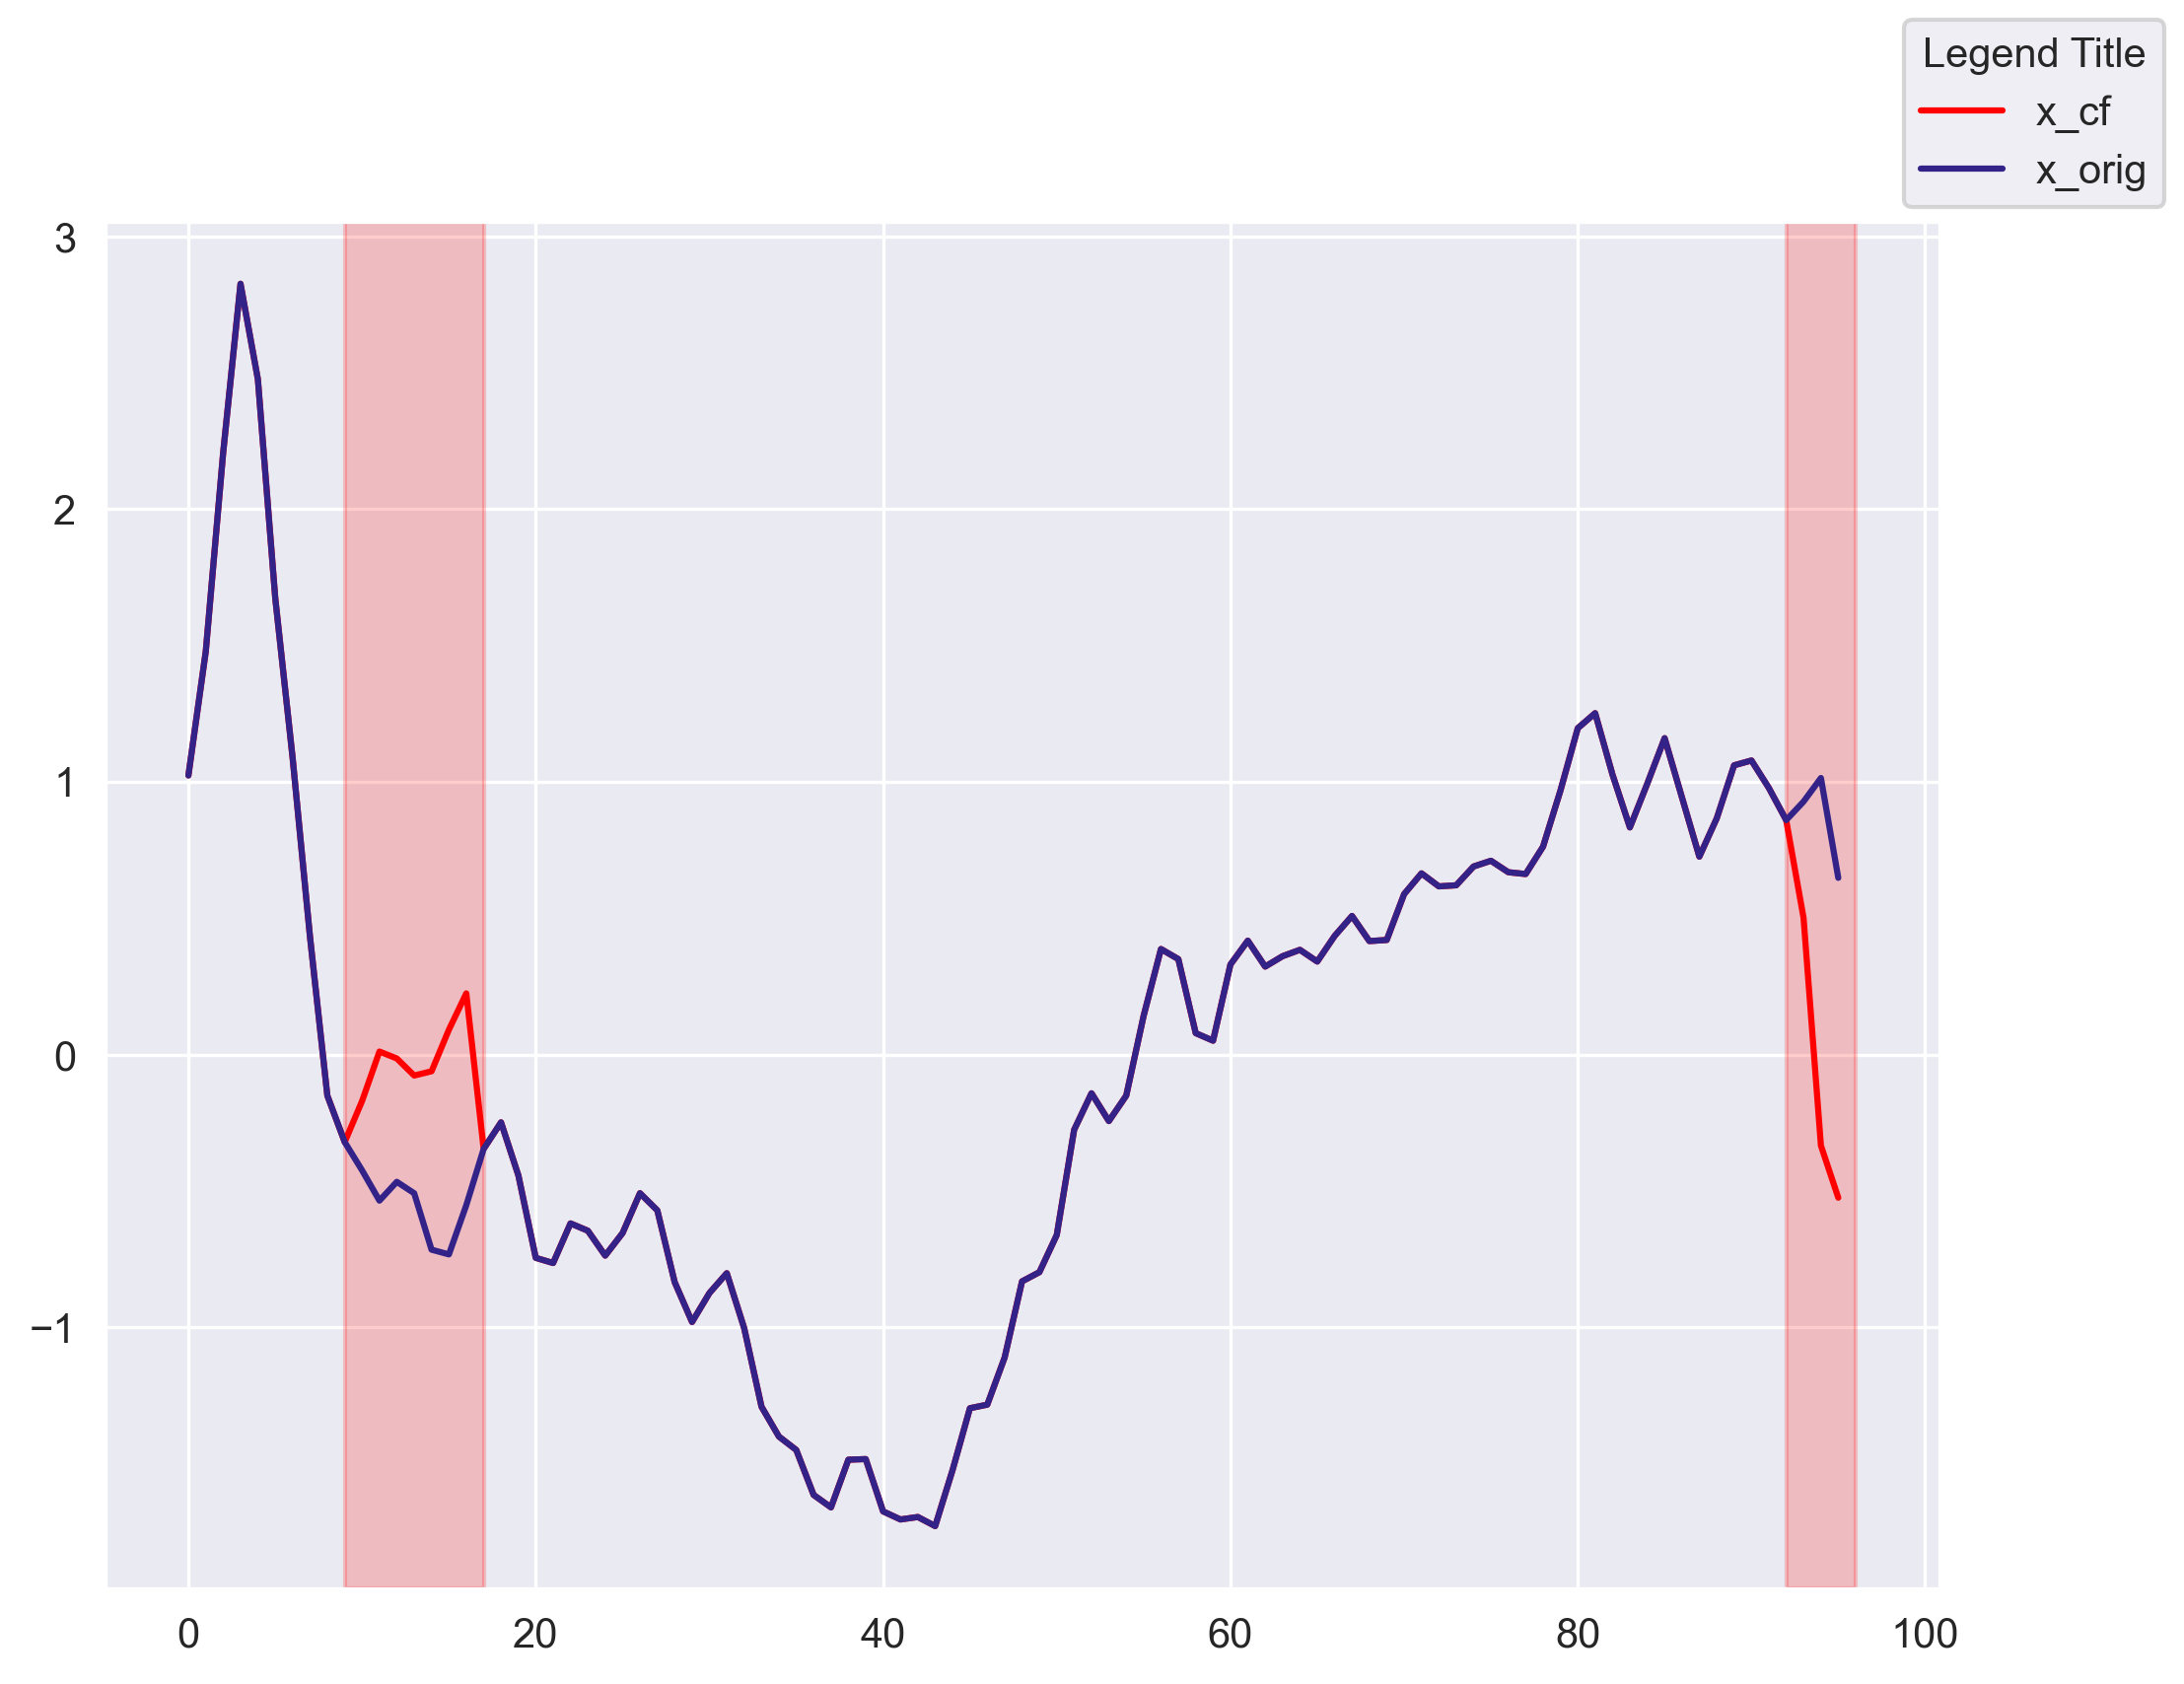

In [73]:
fig = plot_single_cf(X_test[instance], cf_evolutions_subspace_instance[2], figsize=(8, 6))
plt.savefig(f"./experiments/evaluation/gifs/{dataset}/non_cont_cf_i{instance}.png")

fig = plot_single_cf(X_test[instance], cf_evolutions_subspace_instance[100], figsize=(8, 6))
plt.savefig(f"./experiments/evaluation/gifs/{dataset}/cont_cf_i{instance}.png")